# 第一次用tensorflow搭建GAN网络
## import tensorflow和其他package

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

'2.1.0'

可以使用如下命令安装与GIF生成有关的package
<center><mark>!pip install -q imageio <mark>

但由于jupyter安装的环境混乱，放弃使用

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## 加载和准备数据集

将使用MNIST数据集训练生成器和判别器,由于需要翻qiang，这里先把数据集下载下来，然后读取

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data('C:\\Users\\xr chen\\Downloads\\mnist.npz')
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 创建模型
### 生成器
生成器使用 tf.keras.layers.Conv2DTranspose （上采样）层来从种子（随机噪声）中产生图片。以一个使用该种子作为输入的 Dense 层开始，然后多次上采样直到达到所期望的 28x28x1 的图片尺寸。注意除了输出层使用 tanh 之外，其他每层均使用 tf.keras.layers.LeakyReLU 作为激活函数。

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

使用尚未训练的生成器创建一张照片

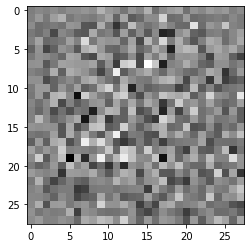

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 判别器
一个基于CNN的图片分类器

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

使用尚未训练的判别器判断真伪，真实图片输出正值，虚假图片输出负值

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00070126]], shape=(1, 1), dtype=float32)


## 定义损失函数和优化器
为两个模型定义损失函数和优化器

In [9]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 判别器损失
量化判别器的判断能力，它将判别器对真实图片的预测值与值全为 1 的数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 生成器损失
生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。这里我们将把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比。

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 保存检查点
本笔记还演示了如何保存和恢复模型，这在长时间训练任务被中断的情况下比较有帮助。

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 定义训练循环

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

训练循环在生成器接收到一个随机种子作为输入时开始。该种子用于生产一张图片。判别器随后被用于区分真实图片（选自训练集）和伪造图片（由生成器生成）。针对这里的每一个模型都计算损失函数，并且计算梯度用于更新生成器与判别器。

In [15]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### 生成与保存图片

In [17]:
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 训练模型
调用上面定义的 train() 方法来同时训练生成器和判别器。注意，训练 GANs 可能是棘手的。重要的是，生成器和判别器不能够互相压制对方（例如，他们以相似的学习率训练）。
在训练之初，生成的图片看起来像是随机噪声。随着训练过程的进行，生成的数字将越来越真实。在大概 50 个 epoch 之后，这些图片看起来像是 MNIST 数字。使用 Colab 中的默认设置可能需要大约 1 分钟每 epoch。

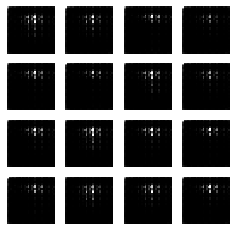

Wall time: 14min 38s


In [18]:
%%time
#train(train_dataset, EPOCHS)#时间太长
train(train_dataset,1)